In [2]:
import time
import os
import seaborn as sns
import numpy as np
import pandas as pd
import sys
%load_ext autoreload
%autoreload 2
from mimas.tools.spectral_file.extract_ms1_feature import process_mzml_file, extract_ms2_spectra, find_features
import logging
from toolsets.spectra_operations import entropy_similarity_default
from toolsets.std_list_prep import complete_adducts, complete_formula
# from toolsets.API_gets import complete_smiles
from toolsets.search import string_search, num_search
import toolsets.spectra_operations as so
from tqdm import tqdm
from toolsets.features_by_alphapept import find_features_alphapept
import matplotlib.pyplot as plt
import seaborn as sns
import toolsets.spectra_plotter as plotter
from toolsets.helpers import find_common_items
from toolsets.API_gets import name_to_smiles
source_dir = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/Elys_low_conc'
data_all = pd.read_csv(os.path.join(source_dir, 'elys_data.csv'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def clean_data(data):
    data.reset_index(inplace=True, drop=True)
    peaks= []
    print('cleaning spectra...')
    for index, row in tqdm(data.iterrows(), total = len(data)):
        peak_temp = so.convert_scc_to_string(row['peaks'])
        peak_temp = so.clean_spectrum(peak_temp, max_mz=row['precursor_mz'], tolerance=0.05)
        peaks.append(peak_temp)
    data['peaks_cleaned']=peaks
    smiles = []
    print('fetching smiles...')
    for name in tqdm(data['name']):
        smiles.append(name_to_smiles(name))
    print('finishing up...')
    data['reference_smiles']=smiles
    data.dropna(subset=['reference_smiles'], inplace=True)
    data.reset_index(inplace=True, drop=True)
    data['adduct']=data['adduct'].replace({'M-H':'[M-H]-', 'M+H':'[M+H]+'})
    data.rename(columns={'adduct':'reference_adduct', 'precursor_mz':'reference_precursor_mz'}, inplace=True)
    return(data)

In [12]:
data_1 = string_search(data_all, 'concentration', 1)
data_1= clean_data(data_1)

cleaning spectra...


100%|██████████| 1058/1058 [00:21<00:00, 50.30it/s]


fetching smiles...


100%|██████████| 1058/1058 [20:12<00:00,  1.15s/it]

finishing up...


In [13]:
data_13 = string_search(data_all, 'concentration', 13)
data_13= clean_data(data_13)

cleaning spectra...


100%|██████████| 347/347 [00:02<00:00, 160.41it/s]


fetching smiles...


100%|██████████| 347/347 [05:28<00:00,  1.06it/s]

finishing up...


In [14]:
data_1.to_csv(os.path.join(source_dir, 'data_1.csv'), index=False)
data_13.to_csv(os.path.join(source_dir, 'data_13.csv'), index=False)

In [21]:
def get_formula(data):
    from rdkit import Chem
    from rdkit.Chem.rdMolDescriptors import CalcMolFormula
    formula = []
    for index, row in data.iterrows():
        mol_temp = Chem.MolFromSmiles(row['reference_smiles'])
        try:
            formula.append(CalcMolFormula(mol_temp))
        except:
            formula.append(np.NAN)
    data['reference_formula']=formula
    data.dropna(subset=['reference_formula'], inplace=True)
    data.reset_index(inplace = True, drop = True)
    return(data)

In [22]:
data_1 = get_formula(data_1)
data_13=get_formula(data_13)

[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors
[19:13:59] WARNING: not removing hydrogen atom without neighbors


In [27]:
def denoising(data):
    from toolsets.denoising_related_functions import denoise_blacklist
    from toolsets.spectra_operations import calculate_explained_intensity
    msms_d = []
    ei = []
    normalized_entropy = []
    for index, row in tqdm(data.iterrows(), total=len(data)) :
        normalized_entropy.append(so.normalized_entropy(row['peaks_cleaned']))
        try:
            msms_d_temp =(denoise_blacklist(row, typeofmsms = 'peaks_cleaned', mass_error=0.05, ifppm=False))
            msms_d.append(msms_d_temp)
            ei.append(calculate_explained_intensity(msms_d_temp, row['peaks_cleaned'],row['reference_precursor_mz'] ))
        except:
            msms_d.append(np.NAN)
            ei.append(np.NAN)
    data['peaks_denoised'] = msms_d
    data['ei'] = ei
    data['normalized_entropy']=normalized_entropy
    return(data)

In [28]:
data_1_d=denoising(data_1)

100%|██████████| 744/744 [03:00<00:00,  4.13it/s]


In [30]:
data_1_d.head()

,id_spec,id_anno,Formula_fetched,mix,charge,reference_precursor_mz,rt,name,reference_adduct,ce,concentration,peaks,rt_spec,precursor_mz_spec,peaks_cleaned,reference_smiles,reference_formula,peaks_denoised,ei,normalized_entropy
0,1211164,1,NaN,2,pos,481.2237,11.37,Anthothecol,[M+H]+,45,1,50.23012924194336:94622.4765625;66.43620300292...,673.437960,481.223755,50.230129\t0.00788695\n66.436203\t0.00992827\n...,CC(=O)OC1CC2(C)C(CC3OC23C4(C)C1C5(C)C=CC(=O)C(...,C28H32O7,50.230129\t0.00788695\n67.054619\t0.01371029\n...,90.41765,0.816872
1,1211055,3,NaN,2,pos,319.2644,11.17,Allopregnanolone,[M+H]+,45,1,51.2735481262207:3498.046875;57.24148178100586...,657.022680,319.263641,51.273548\t0.14155562\n57.241482\t0.1476671\n7...,CC(=O)C1CCC2C3CC[C@H]4C[C@H](O)CC[C@]4(C)C3CC[...,C21H34O2,51.273548\t0.14155562\n57.241482\t0.1476671\n1...,65.36329,0.979581
2,1208852,8,NaN,2,pos,311.1137,5.73,Picrotin,[M+H]+,45,1,50.98478698730469:56908.58203125;54.1502189636...,330.448656,311.113800,50.984787\t0.00466395\n54.150219\t0.00398392\n...,CC(C)(O)C1C2OC(=O)C1C3(O)CC4OC45C(=O)OC2C35C,C15H18O7,50.984787\t0.00466395\n54.150219\t0.00398392\n...,97.16105,0.736040
3,1208861,9,NaN,2,pos,328.1404,5.73,Picrotin,[M+NH4]+,45,1,51.43901824951172:41712.60546875;59.0496864318...,331.698402,328.140472,51.439018\t0.01170045\n59.049686\t0.07699641\n...,CC(C)(O)C1C2OC(=O)C1C3(O)CC4OC45C(=O)OC2C35C,C15H18O7,59.049686\t0.07699641\n73.09111\t0.01217268\n9...,85.25774,0.767731
4,1208840,10,NaN,2,pos,389.1278,5.73,Picrotin,[M+DMSO+H]+,45,1,61.01113510131836:184118.640625;62.01901626586...,328.698150,389.127991,61.011135\t0.03570441\n62.019016\t0.00671662\n...,CC(C)(O)C1C2OC(=O)C1C3(O)CC4OC45C(=O)OC2C35C,C15H18O7,79.021515\t0.87041187\n82.00885\t0.00093157,87.13434,0.002051


In [31]:
nn_de=[]
for index, row in data_1_d.iterrows():
    nn_de.append(so.normalized_entropy(row['peaks_denoised']))
data_1_d['nn_de']=nn_de


In [32]:
data_1_d['normalized_entropy'].describe()

count    744.000000
mean       0.359228
std        0.287651
min        0.000009
25%        0.106219
50%        0.305343
75%        0.581505
max        0.995173
Name: normalized_entropy, dtype: float64

In [33]:
data_1_d['nn_de'].describe()

count    739.000000
mean       0.351406
std        0.302423
min       -1.000000
25%        0.117028
50%        0.311057
75%        0.560616
max        0.999763
Name: nn_de, dtype: float64

In [29]:
data_13_d=denoising(data_13)

100%|██████████| 258/258 [00:09<00:00, 25.86it/s]


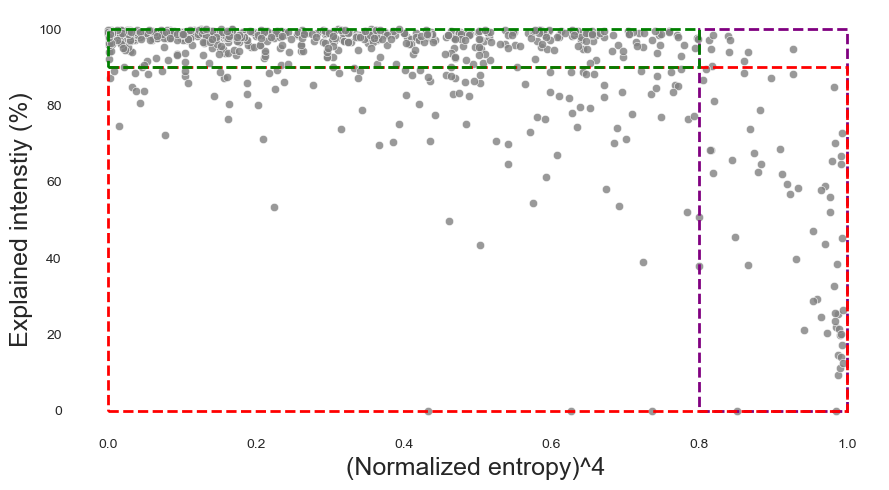

In [137]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )

ax = sns.scatterplot(x = data_1_d['normalized_entropy'],y = data_1_d['ei'],color = 'grey', alpha = 0.8)
ax.set_xlabel("(Normalized entropy)^4", fontsize = 18)
ax.set_ylabel("Explained intenstiy (%)", fontsize = 18)
ax.grid(False)
rect1=mpatches.Rectangle((0.8,0),0.2,100,
                        fill=False,
                        color="purple",
                       linewidth=2, linestyle='dashed')
rect2=mpatches.Rectangle((0,0),1,90,
                        fill=False,
                        color="red",
                       linewidth=2, linestyle='dashed')
rect3=mpatches.Rectangle((0,90),0.8,10,
                        fill=False,
                        color="green",
                       linewidth=2, linestyle='dashed')
                       #facecolor="red")
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor("white")

fig.tight_layout()
plt.savefig(os.path.join(source_dir,'high_quality_spectra.tiff'), dpi = 300,facecolor = 'none', edgecolor = 'none')

In [36]:
bad_quality = num_search(data_1_d, 'ei', number=10, direction='<', inclusion=False)

In [74]:
bad_quality_good_spec = num_search(bad_quality, 'normalized_entropy', number=0.8, direction='<')

In [76]:
from toolsets.spectra_plotter import ms2_plot

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


In [78]:
bad_quality_good_spec

,id_spec,id_anno,Formula_fetched,mix,charge,reference_precursor_mz,rt,name,reference_adduct,ce,...,peaks,rt_spec,precursor_mz_spec,peaks_cleaned,reference_smiles,reference_formula,peaks_denoised,ei,normalized_entropy,nn_de
198,2755056,313,NaN,6,neg,181.0781,4.87,Harmane,[M-H]-,45,...,60.525638580322266:3068.500244140625;71.687942...,293.883216,181.077469,60.525639\t0.08941568\n71.687943\t0.09007567\n...,CC1=NCCc2c1[nH]c3ccccc23,C12H12N2,NaN,0.0,0.735650,NaN
234,3480383,353,NaN,7,neg,167.1087,9.03,Chrysanthemic Acid,[M-H]-,45,...,138.92958068847656:6940.23388671875;161.215866...,540.700740,167.107925,138.929581\t0.69318282\n161.215866\t0.30681718,CC(C)=C[C@@H]1[C@@H](C(O)=O)C1(C)C,C10H16O2,NaN,0.0,0.625916,NaN
722,2966488,353,NaN,7,neg,167.1087,9.03,Chrysanthemic Acid,[M-H]-,35,...,54.634918212890625:2950.27197265625;108.407623...,540.198750,167.108063,54.634918\t0.10273442\n108.407623\t0.10795522\...,CC(C)=C[C@@H]1[C@@H](C(O)=O)C1(C)C,C10H16O2,NaN,0.0,0.432459,NaN


In [92]:
instance=bad_quality_good_spec.iloc[2]
so.convert_string_to_nist(instance['peaks_cleaned'])

array([[5.4634918e+01, 1.0273442e-01],
       [1.0840762e+02, 1.0795522e-01],
       [1.3286885e+02, 1.3270830e-01],
       [1.3892975e+02, 5.5266869e-01],
       [1.4596822e+02, 1.0393337e-01]], dtype=float32)

In [ ]:
from toolsets.spectra_plotter import

In [94]:
instance['reference_precursor_mz']-108.407623

58.701077

In [96]:
from rdkit import  Chem

In [99]:
instance

id_spec                                                             2966488
id_anno                                                                 353
Formula_fetched                                                         NaN
mix                                                                       7
charge                                                                  neg
reference_precursor_mz                                             167.1087
rt                                                                     9.03
name                                                     Chrysanthemic Acid
reference_adduct                                                     [M-H]-
ce                                                                       35
concentration                                                             1
peaks                     54.634918212890625:2950.27197265625;108.407623...
rt_spec                                                           540.19875
precursor_mz

In [100]:
mol = Chem.MolFromSmiles(instance['reference_smiles'])
from rdkit.Chem import Draw
Draw.MolToFile(mol,os.path.join(source_dir, 'nn4.png'))

In [110]:
bad_quality_good_spec

,id_spec,id_anno,Formula_fetched,mix,charge,reference_precursor_mz,rt,name,reference_adduct,ce,...,peaks,rt_spec,precursor_mz_spec,peaks_cleaned,reference_smiles,reference_formula,peaks_denoised,ei,normalized_entropy,nn_de
198,2755056,313,NaN,6,neg,181.0781,4.87,Harmane,[M-H]-,45,...,60.525638580322266:3068.500244140625;71.687942...,293.883216,181.077469,60.525639\t0.08941568\n71.687943\t0.09007567\n...,CC1=NCCc2c1[nH]c3ccccc23,C12H12N2,NaN,0.0,0.735650,NaN
234,3480383,353,NaN,7,neg,167.1087,9.03,Chrysanthemic Acid,[M-H]-,45,...,138.92958068847656:6940.23388671875;161.215866...,540.700740,167.107925,138.929581\t0.69318282\n161.215866\t0.30681718,CC(C)=C[C@@H]1[C@@H](C(O)=O)C1(C)C,C10H16O2,NaN,0.0,0.625916,NaN
722,2966488,353,NaN,7,neg,167.1087,9.03,Chrysanthemic Acid,[M-H]-,35,...,54.634918212890625:2950.27197265625;108.407623...,540.198750,167.108063,54.634918\t0.10273442\n108.407623\t0.10795522\...,CC(C)=C[C@@H]1[C@@H](C(O)=O)C1(C)C,C10H16O2,NaN,0.0,0.432459,NaN


In [111]:
167.1087-161.216

5.892699999999991

In [108]:
instance = bad_quality_good_spec.iloc[0]
mol = Chem.MolFromSmiles(instance['reference_smiles'])
from rdkit.Chem import Draw
Draw.MolToFile(mol,os.path.join(source_dir, 'nn7.png'))

In [109]:
so.convert_string_to_nist(instance['peaks_cleaned'])

array([[6.0525639e+01, 8.9415677e-02],
       [7.1687943e+01, 9.0075672e-02],
       [7.2460640e+01, 9.4522111e-02],
       [9.2920219e+01, 3.3919480e-01],
       [1.3717998e+02, 1.0031385e-01],
       [1.4349124e+02, 9.5549323e-02],
       [1.4753958e+02, 9.2118390e-02],
       [1.5164633e+02, 9.8810174e-02]], dtype=float32)

In [133]:
bad_quality_good_spec

i am ms2 spectra plotter, and I have been sideloaded successfully
I have 2 functions, head to tail plot and ms2 plot


,id_spec,id_anno,Formula_fetched,mix,charge,reference_precursor_mz,rt,name,reference_adduct,ce,...,peaks,rt_spec,precursor_mz_spec,peaks_cleaned,reference_smiles,reference_formula,peaks_denoised,ei,normalized_entropy,nn_de
198,2755056,313,NaN,6,neg,181.0781,4.87,Harmane,[M-H]-,45,...,60.525638580322266:3068.500244140625;71.687942...,293.883216,181.077469,60.525639\t0.08941568\n71.687943\t0.09007567\n...,CC1=NCCc2c1[nH]c3ccccc23,C12H12N2,NaN,0.0,0.735650,NaN
234,3480383,353,NaN,7,neg,167.1087,9.03,Chrysanthemic Acid,[M-H]-,45,...,138.92958068847656:6940.23388671875;161.215866...,540.700740,167.107925,138.929581\t0.69318282\n161.215866\t0.30681718,CC(C)=C[C@@H]1[C@@H](C(O)=O)C1(C)C,C10H16O2,NaN,0.0,0.625916,NaN
722,2966488,353,NaN,7,neg,167.1087,9.03,Chrysanthemic Acid,[M-H]-,35,...,54.634918212890625:2950.27197265625;108.407623...,540.198750,167.108063,54.634918\t0.10273442\n108.407623\t0.10795522\...,CC(C)=C[C@@H]1[C@@H](C(O)=O)C1(C)C,C10H16O2,NaN,0.0,0.432459,NaN


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/alphapept_env/lib/python3.8/site-packages/matplotlib/pyplot.py'>

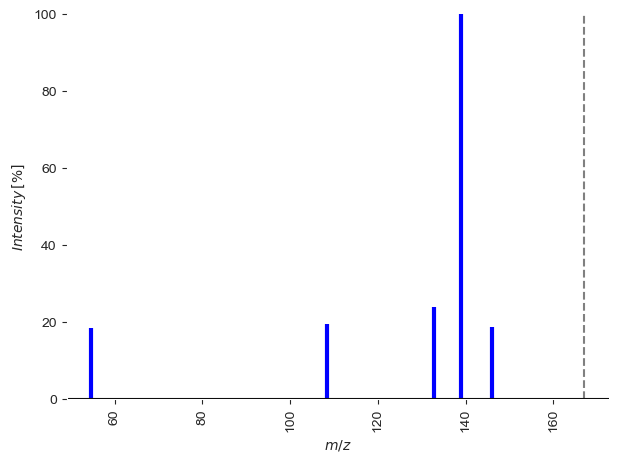

In [136]:
instance = bad_quality_good_spec.iloc[2]
ms2_plot(instance['peaks_cleaned'], pmz1=instance['reference_precursor_mz'], savepath=os.path.join(source_dir,'nn4.tiff'))

In [ ]:
from toolsets.spectra_plotter import ms2_plot


In [39]:
instance = bad_quality.iloc[5]

In [42]:
so.convert_string_to_nist(instance['peaks_cleaned'])

array([[5.4634918e+01, 1.0273442e-01],
       [1.0840762e+02, 1.0795522e-01],
       [1.3286885e+02, 1.3270830e-01],
       [1.3892975e+02, 5.5266869e-01],
       [1.4596822e+02, 1.0393337e-01]], dtype=float32)

In [114]:
data_1.columns

Index(['id_spec', 'id_anno', 'Formula_fetched', 'mix', 'charge',
       'reference_precursor_mz', 'rt', 'name', 'reference_adduct', 'ce',
       'concentration', 'peaks', 'rt_spec', 'precursor_mz_spec',
       'peaks_cleaned', 'reference_smiles', 'reference_formula',
       'peaks_denoised', 'ei', 'normalized_entropy', 'nn_de'],
      dtype='object')

In [116]:
len(num_search(data_1, 'ei', 90, direction='>', inclusion=True))/len(data_1)

0.7701612903225806

In [128]:
high_ei = num_search(data_13, 'ei', 90, direction='>', inclusion=True)

In [132]:
len(num_search(high_ei,'normalized_entropy', 0.8, direction='<', inclusion=False))

13

In [129]:
len(num_search(high_ei,'normalized_entropy', 0.8, direction='<', inclusion=False))/len(data_13)

0.050387596899224806

In [125]:
1-len(num_search(data_13_d, 'normalized_entropy', 0.8, direction='<', inclusion=False))/len(data_13_d)

0.44573643410852715

In [124]:
1-len(num_search(data_13_d, 'ei', 90, direction='>', inclusion=True))/len(data_13)

0.9457364341085271

In [118]:
len(num_search(data_1, 'normalized_entropy', 0.8, direction='<', inclusion=False))/len(data_1)

0.9059139784946236

In [119]:
len(num_search(data_1, 'normalized_entropy', 0.8, direction='<', inclusion=True))/len(data_1)

0.9059139784946236

In [45]:
instance['reference_formula']

'C10H16O2'

In [43]:
instance['precursor_mz_spec']-

167.108062744141

In [44]:
167.108062744141-145.968216

21.139846744140982

In [113]:
len(data_13)/len(data_1)

0.3467741935483871

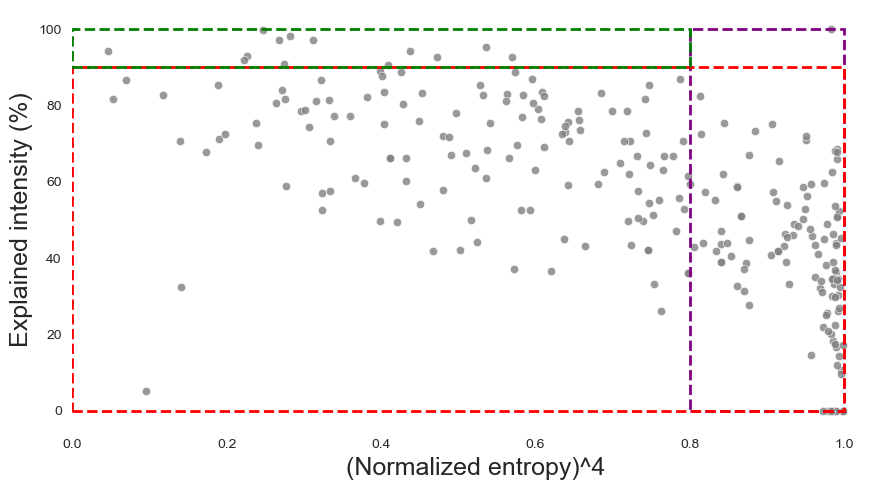

In [71]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(
    figsize = (9, 5)
                      )

# ax = sns.scatterplot(x = data_1['normalized_entropy'],y = data_1['ei'],color = 'green')
ax = sns.scatterplot(x = data_13['normalized_entropy'],y = data_13['ei'],color = 'grey', alpha = 0.8)
ax.set_xlabel("(Normalized entropy)^4", fontsize = 18)
ax.set_ylabel("Explained intensity (%)", fontsize = 18)
ax.grid(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_facecolor("white")
# plt.axvline(0.8, 0, color = 'red' )
# plt.axhline(90, 0, color = 'red' )
rect1=mpatches.Rectangle((0.8,0),0.2,100,
                        fill=False,
                        color="purple",
                       linewidth=2, linestyle='dashed')
rect2=mpatches.Rectangle((0,0),1,90,
                        fill=False,
                        color="red",
                       linewidth=2, linestyle='dashed')
rect3=mpatches.Rectangle((0,90),0.8,10,
                        fill=False,
                        color="green",
                       linewidth=2, linestyle='dashed')
                       #facecolor="red")
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)
fig.tight_layout()
plt.savefig(os.path.join(source_dir,'low_quality_spectra.tiff'), dpi = 300,facecolor = 'none', edgecolor = 'none')

In [115]:
bad_1 = num_search(data_1, 'ei', 90, direction='<', inclusion=True)

In [117]:
bad_1.reset_index(inplace=True, drop=True)

In [124]:
bad_1.iloc[8]

id_spec                                                             2860928
id_anno                                                                  83
mix                                                                       3
charge                                                                  pos
reference_precursor_mz                                             283.0587
rt                                                                     6.51
name                                2,3,4'-Trihydroxy-4-Methoxybenzophenone
reference_adduct                                                    [M+Na]+
ce                                                                       45
concentration                                                             1
peaks                     50.73485565185547:9425.169921875;54.1692390441...
rt_spec                                                          389.376444
precursor_mz_spec                                                283.058685
peaks_cleane

In [121]:
so.convert_string_to_nist(bad_1.iloc[8]['peaks_cleaned'])

array([[5.0734856e+01, 6.5946102e-02],
       [5.4169239e+01, 6.3212469e-02],
       [5.4370113e+01, 6.2046722e-02],
       [5.4441288e+01, 6.0214650e-02],
       [5.5466351e+01, 6.2044900e-02],
       [5.8660717e+01, 6.1258350e-02],
       [5.8879154e+01, 6.8457693e-02],
       [5.9806122e+01, 6.9463998e-02],
       [7.3294762e+01, 7.6273680e-02],
       [8.1825645e+01, 8.9959912e-02],
       [9.0677856e+01, 7.0173971e-02],
       [1.0491871e+02, 7.9836540e-02],
       [1.3617058e+02, 7.8876831e-02],
       [2.0564766e+02, 9.2234209e-02]], dtype=float32)

In [128]:
from toolsets.denoising_related_functions import denoise_single

In [131]:
instance

id_spec                                                             2860928
id_anno                                                                  83
mix                                                                       3
charge                                                                  pos
reference_precursor_mz                                             283.0587
rt                                                                     6.51
name                                2,3,4'-Trihydroxy-4-Methoxybenzophenone
reference_adduct                                                    [M+Na]+
ce                                                                       45
concentration                                                             1
peaks                     50.73485565185547:9425.169921875;54.1692390441...
rt_spec                                                          389.376444
precursor_mz_spec                                                283.058685
peaks_cleane

In [ ]:
prep_formula

In [125]:
msms = so.bin_spectrum(bad_1.iloc[8]['peaks_cleaned'], precursormz= 283.0587)

In [129]:
mass, intensity = so.break_spectra(msms)

In [ ]:
normalized_entropy = []
peaks_denoised = []
for index, row in tqdm(data_1.iterrows(), total = len(data_1)):
    normalized_entropy.append(so.normalized_entropy(row['peaks_cleaned']))
data_1['normalized_entropy']=normalized_entropy

In [23]:
data_13 = string_search(data_all, 'concentration',13)
data_13.reset_index(inplace=True, drop=True)
peaks = []
for index, row in data_13.iterrows():
    peak_temp = so.convert_scc_to_string(row['peaks'])
    peak_temp = so.clean_spectrum(peak_temp, max_mz=row['precursor_mz'], tolerance=0.05)

    peaks.append(peak_temp)

In [49]:
smiles = []
for name in tqdm(data_13['name']):
    smiles.append(name_to_smiles(name))
data_13['smiles_fetched']=smiles
data_13.dropna(subset=['smiles_fetched'], inplace=True)
data_13.reset_index(inplace=True, drop=True)

100%|██████████| 347/347 [03:11<00:00,  1.81it/s]


In [86]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
formula = []
for index, row in data_13.iterrows():
    mol_temp = Chem.MolFromSmiles(row['reference_smiles'])
    try:
        formula.append(CalcMolFormula(mol_temp))
    except:
        formula.append(np.NAN)


[16:51:22] WARNING: not removing hydrogen atom without neighbors
[16:51:22] WARNING: not removing hydrogen atom without neighbors
[16:51:22] WARNING: not removing hydrogen atom without neighbors
[16:51:22] WARNING: not removing hydrogen atom without neighbors
[16:51:22] WARNING: not removing hydrogen atom without neighbors
[16:51:22] WARNING: not removing hydrogen atom without neighbors


In [57]:
data_13['formula_fetched']=formula

In [62]:
normalized_entropy = []
peaks_denoised = []
for index, row in tqdm(data_13.iterrows(), total = len(data_13)):
    normalized_entropy.append(so.normalized_entropy(row['peaks_cleaned']))
data_13['normalized_entropy']=normalized_entropy

100%|██████████| 258/258 [00:00<00:00, 26274.87it/s]


In [67]:
data_13['adduct']=data_13['adduct'].replace({'M-H':'[M-H]-', 'M+H':'[M+H]+'})

In [72]:
data_13.columns

Index(['id_spec', 'id_anno', 'mix', 'charge', 'reference_precursor_mz', 'rt',
       'name', 'reference_adduct', 'ce', 'concentration', 'peaks', 'rt_spec',
       'precursor_mz_spec', 'peaks_cleaned', 'reference_smiles',
       'formula_fetched', 'normalized_entropy'],
      dtype='object')

In [71]:
data_13.rename(columns={'adduct':'reference_adduct', 'precursor_mz':'reference_precursor_mz','smiles_fetched':'reference_smiles'}, inplace=True)

In [73]:
from toolsets.denoising_related_functions import denoise_blacklist
from toolsets.spectra_operations import calculate_explained_intensity
msms_d = []
ei = []
for index, row in tqdm(data_13.iterrows(), total=len(data_13)) :
    try:
        msms_d_temp =(denoise_blacklist(row, typeofmsms = 'peaks_cleaned', mass_error=0.05, ifppm=False))
        msms_d.append(msms_d_temp)
        ei.append(calculate_explained_intensity(msms_d_temp, row['peaks_cleaned'],row['reference_precursor_mz'] ))
    except:
        msms_d.append(np.NAN)
        ei.append(np.NAN)
data_13['peaks_denoised'] = msms_d
data_13['ei'] = ei
# data_13['c_id']=np.arange(len(for_denoise))
# for_denoise.to_csv(os.path.join(source_dir, filename.split('.')[:-1][0]+'_denoised.csv'), index = False)

100%|██████████| 258/258 [00:09<00:00, 26.08it/s]


In [74]:
data_13['ei'].describe()

count    258.000000
mean      56.219046
std       23.330363
min        0.000000
25%       41.748380
50%       57.665125
75%       74.887455
max      100.000000
Name: ei, dtype: float64

In [80]:
num_search(data_13,column_name='ei', number=90, direction='>', inclusion=False).shape

(14, 19)

In [81]:
14/data_13.shape[0]

0.05426356589147287

<AxesSubplot:xlabel='normalized_entropy', ylabel='ei'>

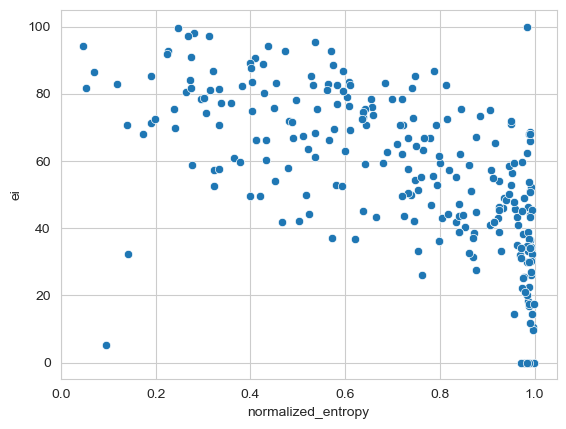

In [84]:
sns.scatterplot(x = data_13['normalized_entropy'],y = data_13['ei'])

In [9]:
# EAD_source = '/Users/fanzhoukong/Documents/GitHub/Libgen_data/EAD'
# UVPD_source = "/Users/fanzhoukong/Documents/GitHub/Libgen_data/UVPD"

In [ ]:
extra

In [ ]:
smiles = []
for name in tqdm(extracted_wanted['name']):
    smiles.append(name_to_smiles(name))


  0%|          | 43/9695 [00:24<1:46:27,  1.51it/s]

In [7]:
extracted_wanted['smiles_fetched']=smiles

In [8]:
extracted_wanted.shape

(242, 14)

In [9]:
extracted_wanted.dropna(subset=['smiles_fetched'], inplace=True)

In [11]:
extracted_wanted.reset_index(inplace=True, drop=True)

In [17]:
extracted_wanted['concentration'].value_counts()

1     48
2     31
3     22
4     21
5     18
7     10
6      7
8      5
9      4
11     3
10     2
12     2
13     2
Name: concentration, dtype: int64

In [14]:
mix_12= string_search(extracted_wanted, 'mix', 12)

In [18]:
mix_12

,id_spec,id_anno,mix,charge,precursor_mz,rt,name,adduct,ce,concentration,peaks,rt_spec,precursor_mz_spec,smiles_fetched
10,342594,210,12,pos,146.1657,0.56,SPERMIDINE,[M+H]+,0,3,51.12116622924805:13.024999618530273;54.827529...,36.701,146.164932,NCCCCNCCCN
11,344640,235,12,pos,363.2180,6.86,HYDROCORTISONE,[M+H]+,0,3,54.521629333496094:14.125;56.67998504638672:7....,399.056,363.215070,C[C@]12CCC(=O)C=C1CC[C@H]3[C@@H]4CC[C@](O)(C(=...
20,682538,370,12,neg,283.0609,9.17,Biochanin A,M-H,0,3,52.409542083740234:69.01786041259766;52.412597...,556.748,283.062791,COc1ccc(cc1)C2=COc3cc(O)cc(O)c3C2=O
21,682532,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,3,51.81279754638672:28.0;54.822967529296875:7.0;...,556.057,407.282505,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
23,822146,230,12,pos,347.1501,5.24,Gibberellic Acid,[M+H]+,0,8,50.65410614013672:17.225000381469727;52.225910...,312.069,347.167542,CC12[C@@H](O)C=C[C@@]3(OC1=O)[C@@H]4CC[C@]5(O)...
26,838672,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,8,50.628692626953125:5.375;50.69906997680664:7.2...,554.298,407.282227,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
32,485564,210,12,pos,146.1657,0.56,SPERMIDINE,[M+H]+,0,7,50.16026306152344:27.0;50.267398834228516:22.6...,42.768,146.164780,NCCCCNCCCN
36,476550,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,7,50.28374481201172:9.0;50.36776351928711:8.0;51...,540.230,407.282111,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
50,609165,210,12,pos,146.1657,0.56,SPERMIDINE,[M+H]+,0,5,50.857200622558594:16.160715103149414;51.08386...,42.686,146.164932,NCCCCNCCCN
58,393132,370,12,neg,283.0609,9.17,Biochanin A,M-H,0,5,50.111263275146484:79.88970947265625;50.115936...,554.502,283.062520,COc1ccc(cc1)C2=COc3cc(O)cc(O)c3C2=O


In [19]:
string_search(extracted_wanted, 'name','Cholic Acid' )

,id_spec,id_anno,mix,charge,precursor_mz,rt,name,adduct,ce,concentration,peaks,rt_spec,precursor_mz_spec,smiles_fetched
21,682532,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,3,51.81279754638672:28.0;54.822967529296875:7.0;...,556.057,407.282505,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
26,838672,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,8,50.628692626953125:5.375;50.69906997680664:7.2...,554.298,407.282227,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
36,476550,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,7,50.28374481201172:9.0;50.36776351928711:8.0;51...,540.230,407.282111,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
59,393087,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,5,51.05177688598633:13.5;52.932254791259766:15.1...,546.749,407.282271,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
92,596117,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,2,50.506492614746094:9.0;50.969234466552734:51.8...,551.055,407.282825,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
101,759904,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,6,50.29555130004883:7.375;50.36285400390625:5.0;...,544.916,407.282266,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
149,566075,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,1,50.04560089111328:11.024999618530273;51.503334...,552.831,407.283337,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
170,748332,379,12,neg,407.2791,9.02,Cholic Acid,M-H,0,4,51.05947494506836:8.125;52.84958267211914:34.1...,553.417,407.282550,C[C@H](CCC(O)=O)[C@H]1CC[C@H]2[C@@H]3[C@H](O)C...
